In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
path_file= "diabetes_dataset.csv"

In [3]:
columns_to_delete=["ID","No_Pation","Gender"]
label= "CLASS"
correlation_columns=["Cr"]

In [4]:
def create_dataset(path_file):
    df = pd.read_csv(path_file)
    return df

def rescaler(df):
    scaler = MinMaxScaler()
    columns_to_scale = df.columns.difference([label])
    df_scaled_part = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)
    # Riaggiungi la colonna 'class' senza modificarla
    df_scaled = pd.concat([df_scaled_part, df[label]], axis=1)
    # (Opzionale) Riorganizza le colonne per mantenere l'ordine originale
    df_scaled = df_scaled[df.columns]
    return df_scaled

def create_dataframe_features_selected(df:pd.DataFrame,columns:list):
    return df[columns]

def preprocessing(df):
    df=df.drop(columns= columns_to_delete)
    #eliminazione colonna correlata
    df=df.drop(columns=correlation_columns)
    df[label] = df[label].str.replace(' ', '', regex=False)
    # df = create_dataframe_features_selected(df,all_features)
    df=rescaler(df)
    return df

def balance_dataset_labels(df, percent=0.3):
    # Filtra le righe con label 'Y'
    righe_y = df[df[label] == 'Y']
    # Calcola il numero di righe da rimuovere (30%)
    n_da_rimuovere = int(len(righe_y) * percent)
    # Estrai casualmente le righe da rimuovere
    righe_da_rimuovere = righe_y.sample(n=n_da_rimuovere, random_state=42)
    # Rimuovi queste righe dal dataset originale
    df_filtrato = df.drop(righe_da_rimuovere.index)
    return df_filtrato

def visualize_dataset(df):
    print("shape",df.shape)
    print(df.head())


In [5]:
df=create_dataset(path_file)
df=preprocessing(df)
df=balance_dataset_labels(df)
visualize_dataset(df)

shape (747, 10)
        AGE      Urea     HbA1c      Chol        TG       HDL       LDL  \
0  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
1  0.101695  0.104167  0.264901  0.359223  0.081481  0.092784  0.187500   
2  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
3  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
4  0.220339  0.171875  0.264901  0.475728  0.051852  0.061856  0.177083   

       VLDL       BMI CLASS  
0  0.011461  0.173913     N  
1  0.014327  0.139130     N  
2  0.011461  0.173913     N  
3  0.011461  0.173913     N  
4  0.008596  0.069565     N  


In [6]:
print(df[df[label]=="Y"].count())

AGE      591
Urea     591
HbA1c    591
Chol     591
TG       591
HDL      591
LDL      591
VLDL     591
BMI      591
CLASS    591
dtype: int64


# Visualizziamo il Dataset per coppie di features

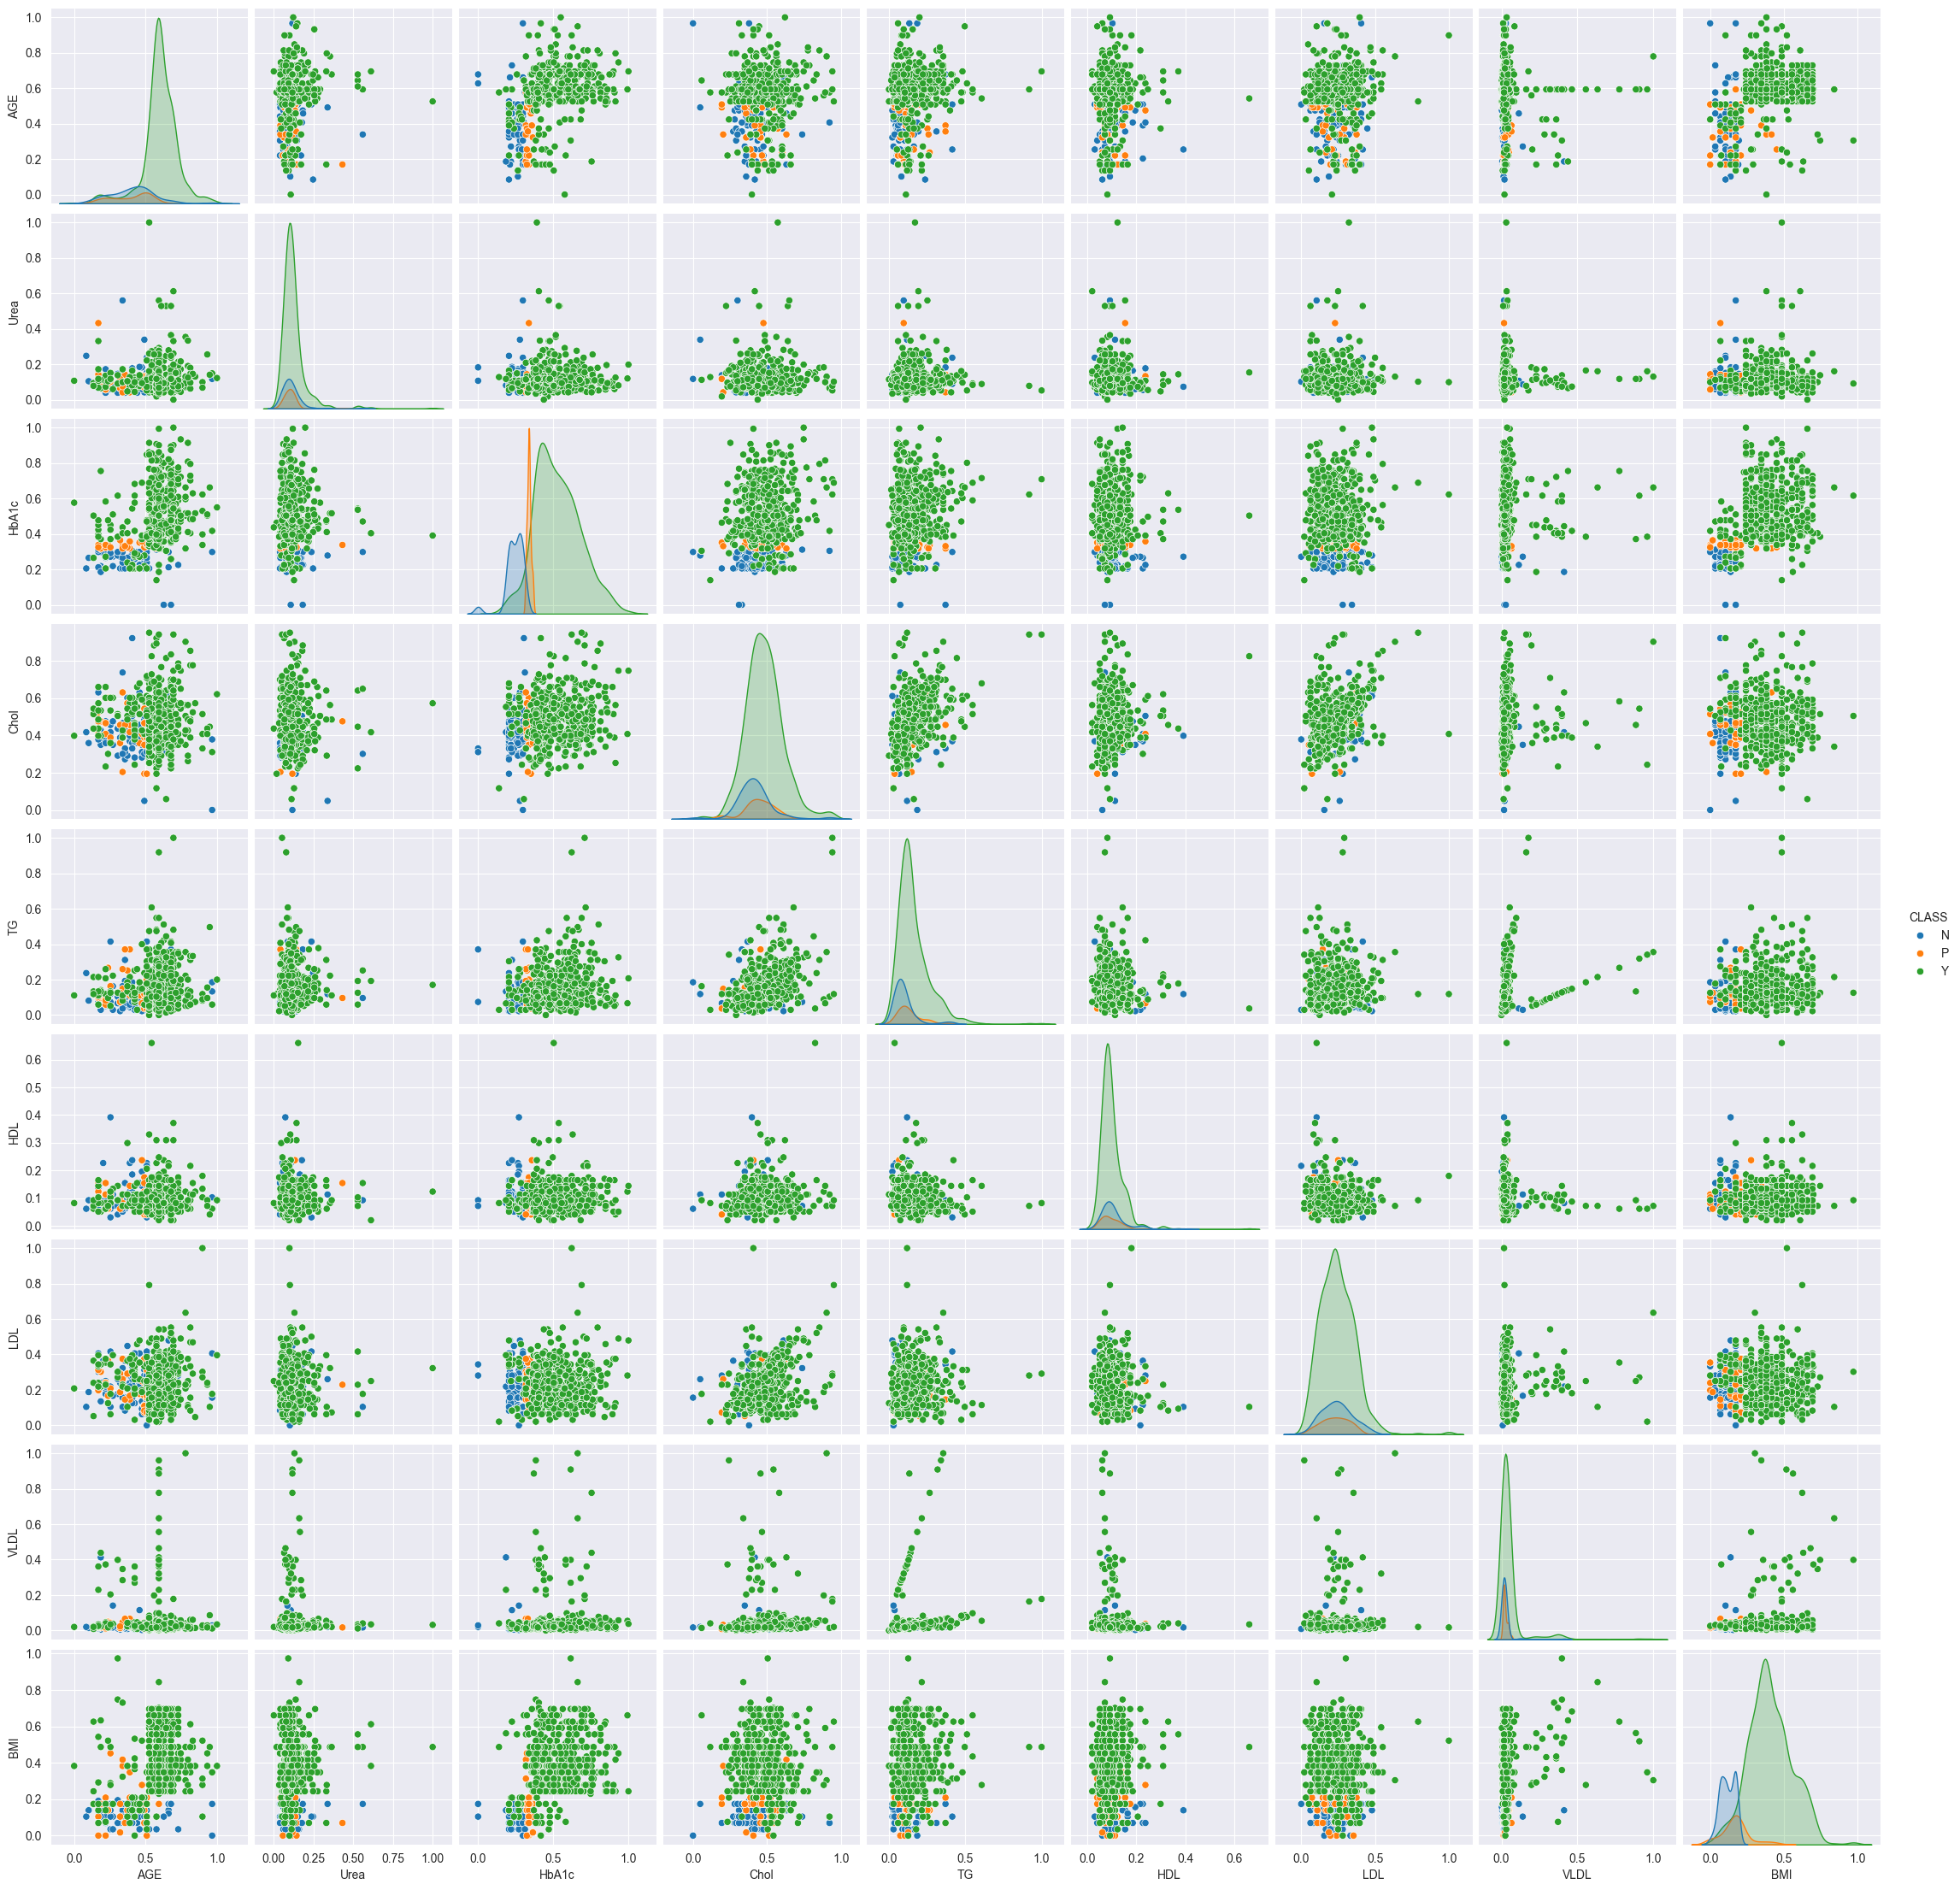

In [7]:
import seaborn as sns
sns.pairplot(df, hue=label, palette="tab10")

### Correlazione

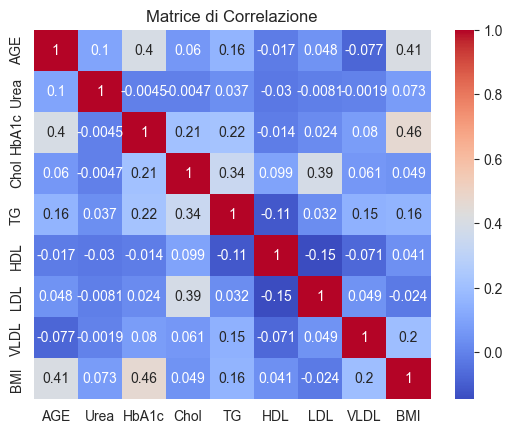

In [8]:
import matplotlib.pyplot as plt

df_corr=df.drop(columns=[label])
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice di Correlazione")
plt.show()

### Features e Label

In [9]:
X = df.drop(label, axis=1)
y = df[label]

### TrainSet e TestSet

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Train (f,l): {len(X_train)}, {len(y_train)}")
print(f"Test (f,l): {len(X_test)}, {len(y_test)}")

Train (f,l): 522, 522
Test (f,l): 225, 225


# Classificatore Classico

In [11]:
dtc=DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

# Valutiamo il classificatore

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred=dtc.predict(X_test)
print(f"test accuracy: {accuracy_score(y_test,y_pred)}")


precision_score= precision_score(y_test, y_pred, average='weighted')  # 'macro', 'micro', 'weighted'
recall_score=recall_score(y_test, y_pred, average='weighted')
f1_score=f1_score(y_test, y_pred, average='weighted')

print(precision_score)
print(recall_score)
print(f1_score)


test accuracy: 0.9911111111111112
0.9912144702842377
0.9911111111111112
0.9910323442665866


# Quantum Variational Classifier

### Circuito per Encoding

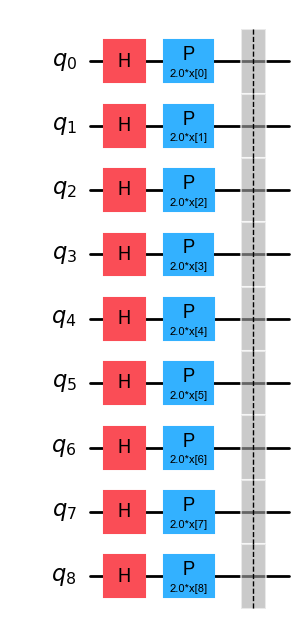

In [13]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

num_features = df.shape[1]-1

#feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
#feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

In [14]:
X_train_new=X_train.values.tolist()
X_test_new=X_test.values.tolist()
y_train_new=y_train.tolist()
y_test_new=y_test.tolist()

### Quantum Circuit Ansatz

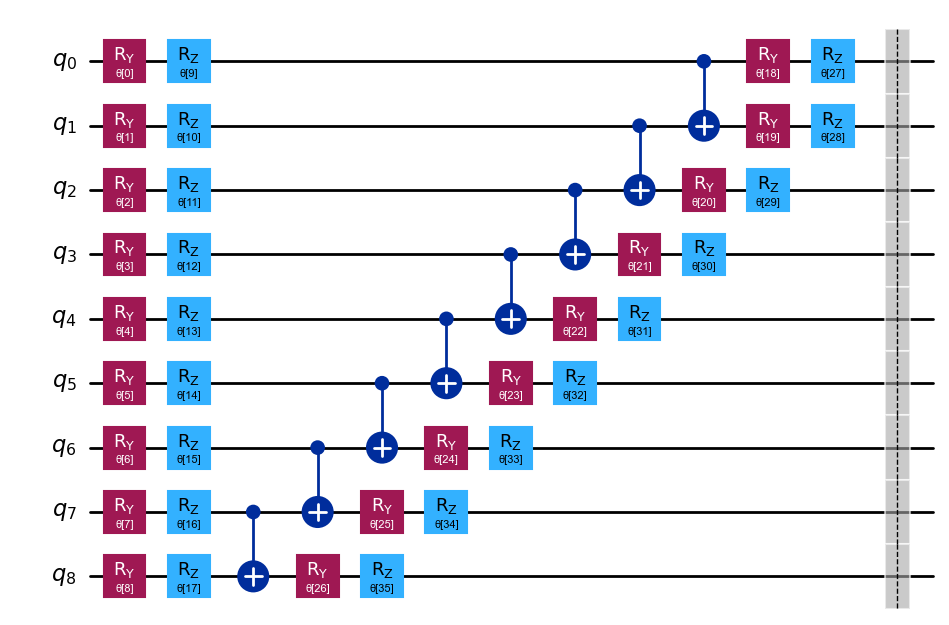

In [17]:
from qiskit.circuit.library import EfficientSU2

ansatz=EfficientSU2(num_features,reps=1)
ansatz.barrier()
ansatz.decompose().draw(output="mpl", fold=20)

## Combiniamo il tutto ed eseguiamo l'algoritmo Variational Quantum Classifier

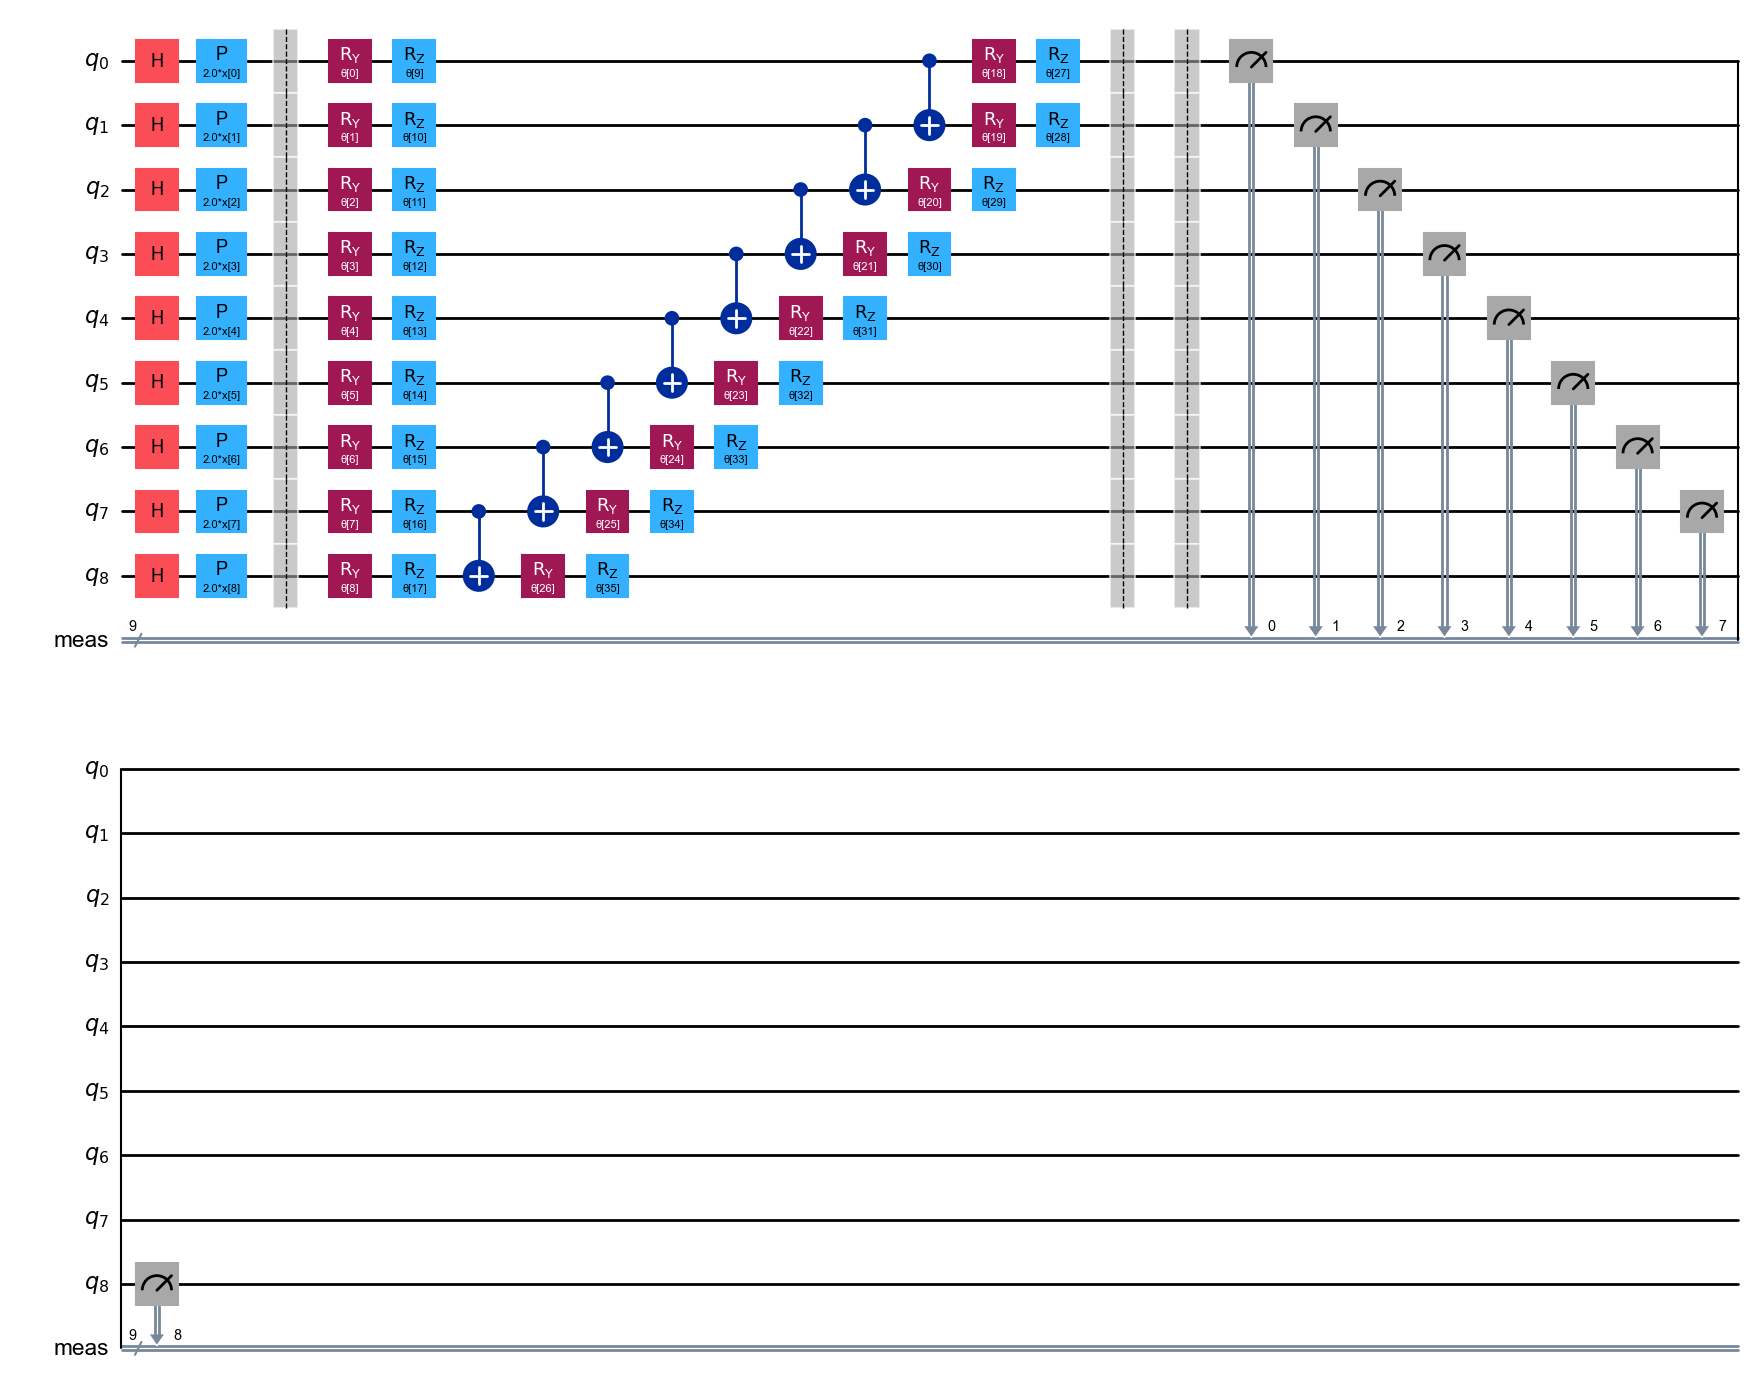

In [18]:
ad_hoc_circuit = feature_map.compose(ansatz)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

### Funzioni di utilità per minimizzare la loss function

In [19]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history = []


def init_history():
    history.clear()


objective_func_vals = []


def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [20]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 3

def label_probability(results):
    shots = sum(results.values())
     #probabilities = {0: 0, 1: 0}
    probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1],p[2]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(X_train_new, y_train_new, variational)

In [21]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()
initial_point = np.zeros((ansatz.num_parameters))
res = minimize(objective_function, initial_point, method="cobyla", options={"maxiter": 5000})

0.6593129953969301


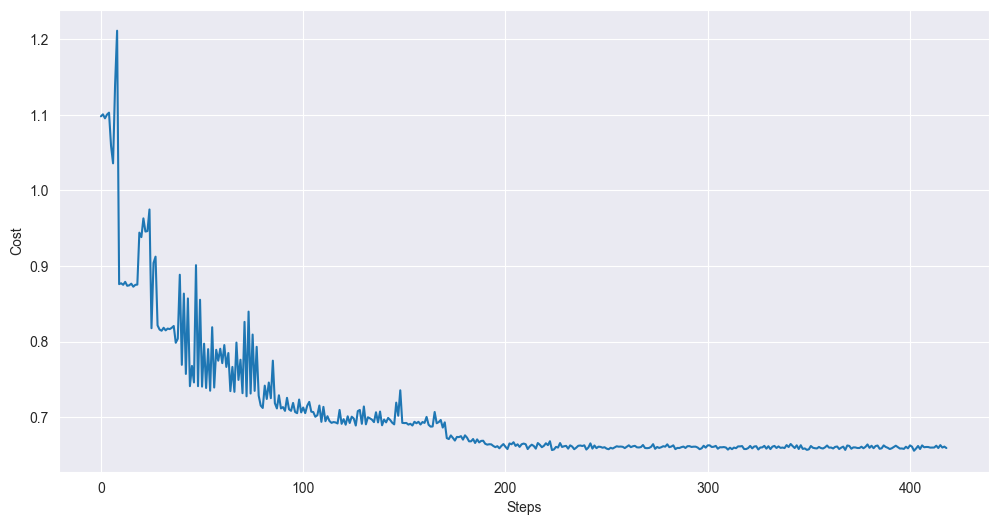

[-0.08115104  1.62320051 -0.98743202 -1.0734989   1.39736284  1.55442242
 -0.19567944 -0.31462371  1.67449527  0.45578395  1.79756304 -0.38801202
  1.59140664  0.36321063 -0.49288574  1.23618532  0.11301379  0.20248427
  0.0039444   0.01577336 -0.02519091  0.10683242  0.09337867  0.01763525
  1.11370349 -0.02359335 -0.10082388 -0.17222138  1.35339455  1.62102747
  0.3307491  -0.37583963  0.48931999  0.00571488 -0.1601497  -0.75011311]
0.6593129953969301


In [22]:
opt_var = res.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_value = res.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_var)
print(opt_value)

In [27]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_train, predictions_train = test_classifier(X_train_new, y_train_new, opt_var)
accuracy_test, predictions_test = test_classifier(X_test_new, y_test_new, opt_var)
print(accuracy_train,accuracy_test)

KeyboardInterrupt: 

In [26]:
accuracy_train=accuracy_score(X_train_new,predictions_train)
accuracy_test=accuracy_score(X_test_new,predictions_test)
print(accuracy_train)
print(accuracy_test)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions_test)

In [ ]:
confusion_matrix(y_train,predictions_train)